# Sugarcane Yield Prediction using Machine Learning

In [2]:
#importing dependancies
import ee
import pandas as pd
import folium
from folium import plugins
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from pylab import rcParams
import seaborn as sns
import keras
from keras import layers, models, Sequential
from sklearn.metrics import mean_squared_error

In [3]:
pip install earthengine-api pandas folium matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [5]:
from shapely.geometry import Polygon
from shapely.ops import transform
import pyproj
from pyproj import Proj, transform

In [6]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [ ]:
ee.Authenticate()

In [ ]:
ee.Initialize()

## Area of interest = Sugarcane Belt of Uttar Pradesh

<img src = "Desktop/Dissertation_files/SugarcaneBelt.jpeg">

In [ ]:
AOI= ee.Geometry.Polygon([
  [
    [80.1728, 28.1124],
    [80.3233, 28.0459],
    [80.3648, 27.9413],
    [80.3476, 27.8406],
    [80.1756, 27.8007],
    [80.0897, 27.8132],
    [80.0149, 27.8557],
    [79.9669, 27.8978],
    [79.9190, 27.9468],
    [79.8889, 27.9993],
    [79.8704, 28.0641],
    [79.8015, 28.1435],
    [79.7522, 28.2381],
    [79.7847, 28.2827],
    [79.7744, 28.3554],
    [79.8495, 28.3964],
    [79.8778, 28.4119]
  ]
])


## Visualising Sentinel-2 Image

In [ ]:
startdate = ee.Date.fromYMD(2021, 7, 1);
enddate = ee.Date.fromYMD(2021, 10, 30);

collection = ee.ImageCollection("COPERNICUS/S2").filterDate(startdate, enddate).filterBounds(AOI).filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 0.1);


In [ ]:
S2 = collection.median().clip(AOI).divide(10000)
vis_params = {'min':0, 'max':0.4, 'bands':['B4', 'B3', 'B2']}

In [ ]:
NDVI = S2.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndvi_params = {'min': 0, 'max': 0.8, 'palette': ['red', 'green','yellow']}

In [1]:
basemaps = {
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    )}

NameError: name 'folium' is not defined

In [ ]:
def add_ee_layer(self, ee_object, vis_params, name):

    try:
        if isinstance(ee_object, ee.image.Image):
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        elif isinstance(ee_object, ee.geometry.Geometry):
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)

    except:
        print("Could not display {}".format(name))

folium.Map.add_ee_layer = add_ee_layer

In [ ]:
map_1 = folium.Map(location=[28.2021, 80.0102], zoom_start=12)

basemaps['Google Terrain'].add_to(map_1)

map_1.add_ee_layer(S2, vis_params, 'Sentinel_2')
map_1.add_ee_layer(NDVI, ndvi_params, 'NDVI')
map_1.add_child(folium.LayerControl())

display(map_1)

## Creating a dataset by collecting NDVI Values

In [ ]:
startDate = ee.Date.fromYMD(2015,1,1)
endDate = ee.Date.fromYMD(2023,1,1)

In [ ]:
s2_sugarcanebelt = ee.ImageCollection("COPERNICUS/S2").filterDate(startDate, endDate).filterBounds(AOI).filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 1)
NDVI_sugarcanebelt = s2_sugarcanebelt.map(lambda image: image.normalizedDifference(['B8', 'B4']).rename('NDVI').copyProperties(image, ['system:time_start']))

In [ ]:
ndvi_time_series = NDVI_sugarcanebelt.reduce(ee.Reducer.mean()).reduceRegion(reducer=ee.Reducer.toList(), geometry=AOI, scale=20).getInfo()

In [ ]:
ndvi_list = ndvi_time_series['NDVI_mean']
dates = NDVI_sugarcanebelt.aggregate_array('system:time_start').getInfo()
dates = [datetime.fromtimestamp(date/1000) for date in dates]

In [ ]:
ndvi_df = pd.DataFrame({'ndvi': ndvi_list[:len(dates)]}, index=dates)
ndvi_df.head()

,ndvi
2015-10-02 05:18:41.000,0.264614
2015-10-02 05:18:41.000,0.261297
2015-10-02 05:18:41.796,0.258235
2015-10-02 05:18:41.796,0.294454
2015-11-14 05:26:04.000,0.294454


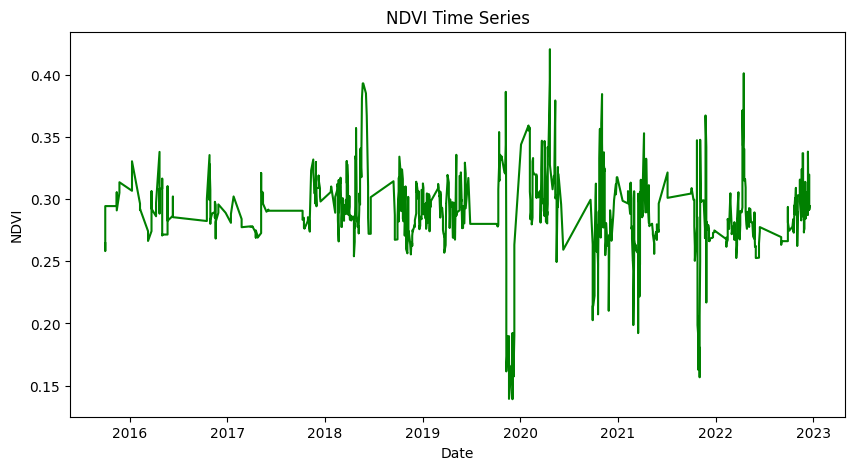

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ndvi_df.index, ndvi_df['ndvi'], color='green')

ax.set_title('NDVI Time Series')
ax.set_xlabel('Date')
ax.set_ylabel('NDVI')

plt.show()

<Axes: >

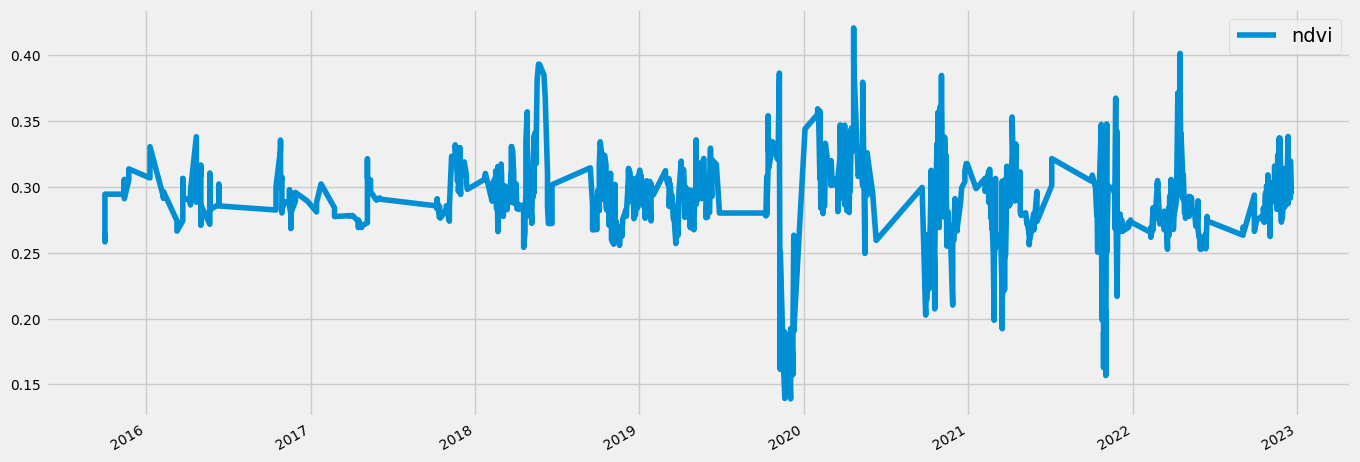

In [ ]:
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['text.color'] = 'k'
plt.style.use('fivethirtyeight')

ndvi_df.plot(figsize=(15,6))

In [ ]:
ndvi_df.reset_index(inplace=True)
ndvi_df.head()

,index,ndvi
0,2015-10-02 05:18:41.000,0.264614
1,2015-10-02 05:18:41.000,0.261297
2,2015-10-02 05:18:41.796,0.258235
3,2015-10-02 05:18:41.796,0.294454
4,2015-11-14 05:26:04.000,0.294454


In [ ]:
ndvi_df['index'] = ndvi_df['index'].dt.date

In [ ]:
ndvi_df['index'] = pd.to_datetime(ndvi_df['index'], format='%Y-%m')
ndvi_df = ndvi_df.set_index('index')

#### Remove duplicates from the index/date column to ensure we have only one ndvi reading per day

In [ ]:
index = ndvi_df.index
is_duplicate = index.duplicated(keep='first')
not_duplicate = ~is_duplicate
ndvi_new = ndvi_df[not_duplicate]
ndvi_new.head()

,ndvi
index,
2015-10-02,0.264614
2015-11-14,0.294454
2015-11-24,0.305179
2016-01-10,0.306767
2016-02-09,0.296424


#### Interpolating data so we have readings for all days.

                ndvi
index               
2015-10-02  0.264614
2015-10-03  0.265308
2015-10-04  0.266002
2015-10-05  0.266696
2015-10-06  0.267390


<Axes: xlabel='index'>

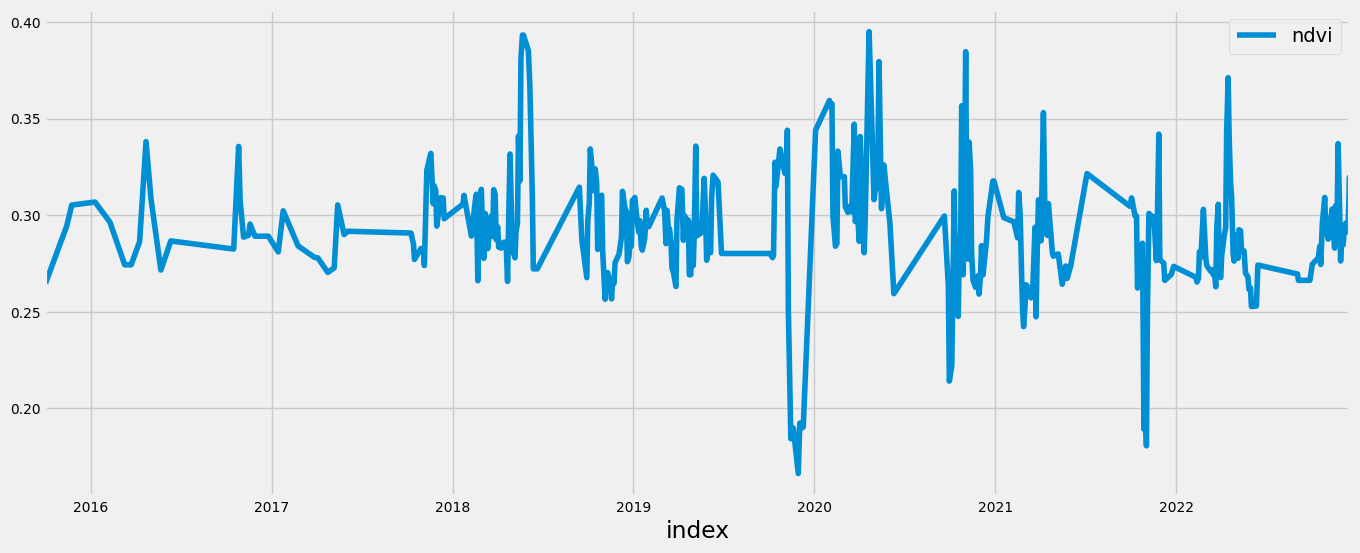

In [ ]:
upsampled = ndvi_new.resample('D')
interpolated = upsampled.interpolate(method='linear')

print(interpolated.head())

interpolated.plot(figsize=(15,6))

In [ ]:
print(type(interpolated))
interpolated.to_csv('ndvi_interpolated.csv', index=True)

<class 'pandas.core.frame.DataFrame'>


#### Converting data to a time_series favourable format

In [ ]:
# def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

#     n_vars = 1 if type(data) is list else data.shape[1]
#     df = pd.DataFrame(data)
#     cols, names = list(), list()

#     for i in range(n_in, 0, -1):
#         cols.append(df.shift(i))
#         names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

#     for i in range(0, n_out):
#         cols.append(df.shift(-i))
#         if i == 0:
#             names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
#         else:
#             names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

#     agg = pd.concat(cols, axis=1)
#     agg.columns = names

#     if dropnan:
#         agg.dropna(inplace=True)
#     return agg

In [ ]:
# values = interpolated.values

# final_df = series_to_supervised(values, 14, 1)

# final_df.head(14)

In [ ]:
output_df = pd.read_csv("final-checkpoint.csv")
print(type(output_df))
output_df.shape
# print(output_df)

duplicate = output_df[output_df.duplicated()]
# print(duplicate)
output_df = output_df.drop_duplicates()
output_df

<class 'pandas.core.frame.DataFrame'>


,ndvi,evaporation_from_vegetation_transpiration_sum,soil_temperature_level_1,surface_net_solar_radiation_sum,temperature_2m,total_precipitation_sum
0,0.294454,0.000000e+00,301.237361,17300000.0,299.785082,0.000000e+00
1,0.294374,0.000000e+00,300.670247,17400000.0,299.757111,1.280000e-06
2,0.294293,0.000000e+00,301.611605,16900000.0,300.595834,0.000000e+00
3,0.294212,0.000000e+00,302.113707,16100000.0,300.924228,1.270000e-06
4,0.294132,0.000000e+00,302.338162,16300000.0,301.113778,8.670000e-07
...,...,...,...,...,...,...
2631,0.305235,0.000000e+00,290.069274,12200000.0,287.988349,0.000000e+00
2632,0.299864,9.310000e-10,289.658445,11900000.0,287.359432,8.550000e-07
2633,0.294492,0.000000e+00,289.583420,11800000.0,288.274115,1.720000e-06
2634,0.288872,0.000000e+00,290.335277,11600000.0,288.646950,2.160000e-06


In [ ]:
# values = output_df.values

# final_df = series_to_supervised(values, 14, 1)

# final_df.head(15)

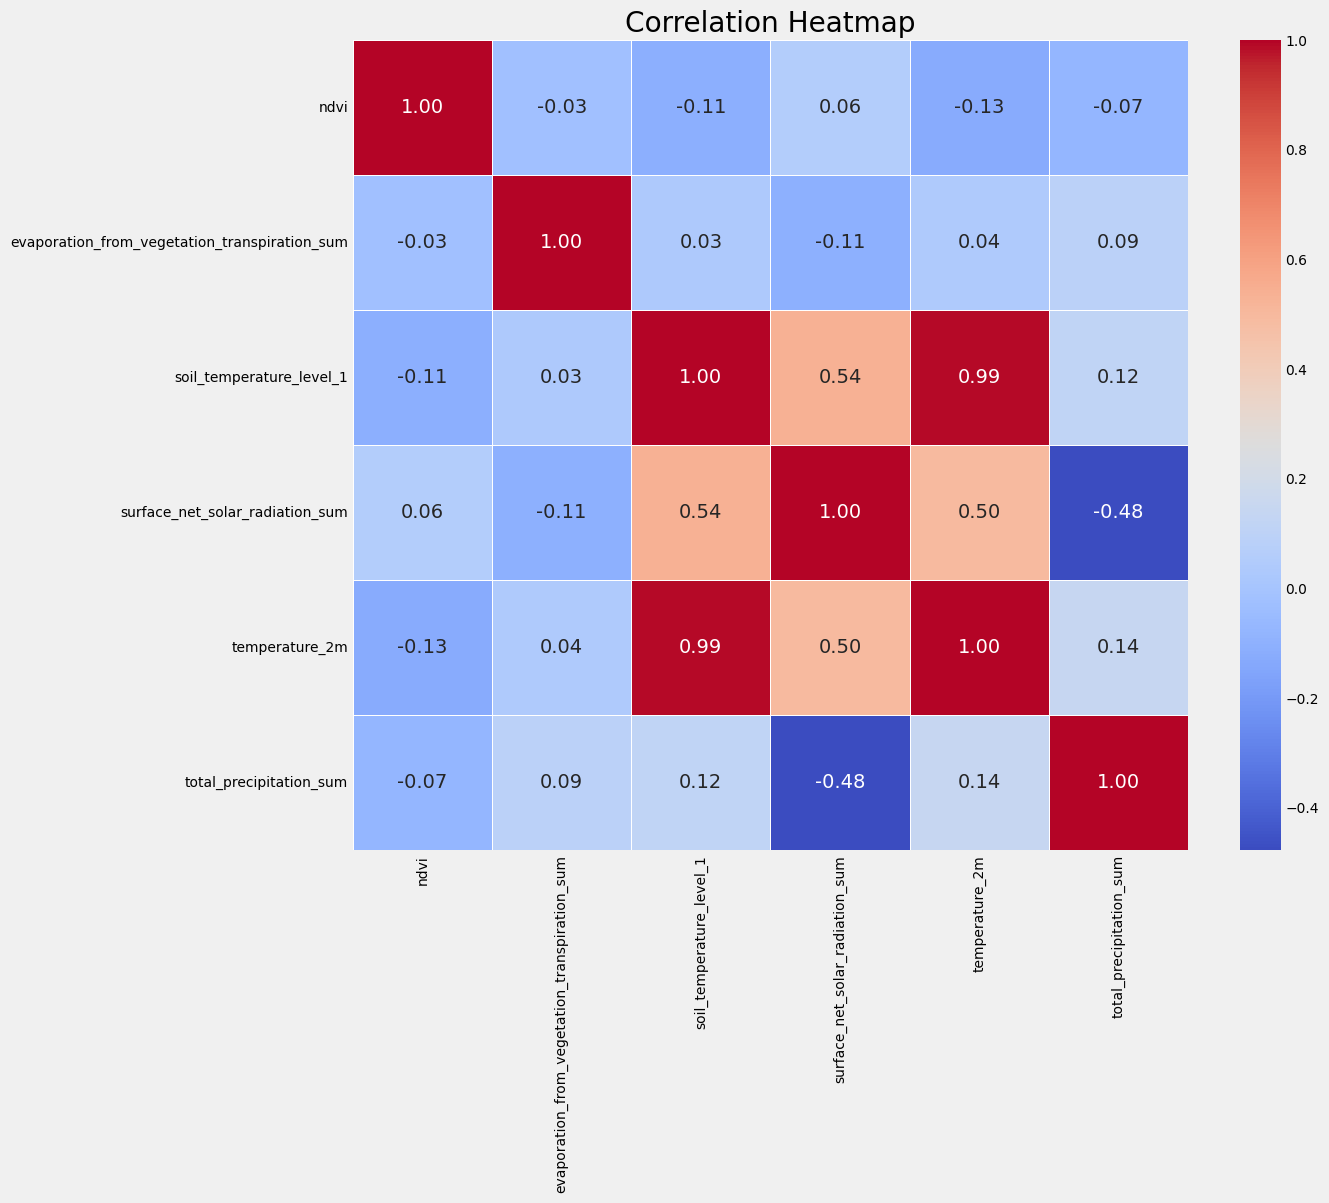

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
csv_file_path = "final-checkpoint.csv"  # Replace with the actual path to your CSV file
df = pd.read_csv(csv_file_path)

# Calculate the correlation matrix for all features
correlation_matrix = df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


##converting to supervised dataset

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
lstm_df = pd.read_csv("final.csv")
print(type(output_df))
output_df.shape


duplicate = output_df[output_df.duplicated()]
# print(duplicate)
output_df = output_df.drop_duplicates()
output_df

<class 'pandas.core.frame.DataFrame'>


,ndvi,evaporation_from_vegetation_transpiration_sum,soil_temperature_level_1,surface_net_solar_radiation_sum,temperature_2m,total_precipitation_sum
0,0.294454,0.000000e+00,301.237361,17300000.0,299.785082,0.000000e+00
1,0.294374,0.000000e+00,300.670247,17400000.0,299.757111,1.280000e-06
2,0.294293,0.000000e+00,301.611605,16900000.0,300.595834,0.000000e+00
3,0.294212,0.000000e+00,302.113707,16100000.0,300.924228,1.270000e-06
4,0.294132,0.000000e+00,302.338162,16300000.0,301.113778,8.670000e-07
...,...,...,...,...,...,...
2631,0.305235,0.000000e+00,290.069274,12200000.0,287.988349,0.000000e+00
2632,0.299864,9.310000e-10,289.658445,11900000.0,287.359432,8.550000e-07
2633,0.294492,0.000000e+00,289.583420,11800000.0,288.274115,1.720000e-06
2634,0.288872,0.000000e+00,290.335277,11600000.0,288.646950,2.160000e-06


In [ ]:
values = lstm_df.values

lstm_model_df = series_to_supervised(values, 14, 1)

lstm_model_df.head(15)

,var1(t-14),var2(t-14),var3(t-14),var4(t-14),var5(t-14),var6(t-14),var1(t-13),var2(t-13),var3(t-13),var4(t-13),...,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
14,0.0,301.237361,17300000.0,299.785082,0.000000e+00,0.294454,0.0,300.670247,17400000.0,299.757111,...,1.350000e+07,298.301285,2.557506e-03,0.293406,0.000000e+00,300.686545,1.390000e+07,298.772994,3.830000e-04,0.293325
15,0.0,300.670247,17400000.0,299.757111,1.280000e-06,0.294374,0.0,301.611605,16900000.0,300.595834,...,1.390000e+07,298.772994,3.830000e-04,0.293325,0.000000e+00,300.895984,1.430000e+07,299.103853,1.250000e-04,0.293245
16,0.0,301.611605,16900000.0,300.595834,0.000000e+00,0.294293,0.0,302.113707,16100000.0,300.924228,...,1.430000e+07,299.103853,1.250000e-04,0.293245,9.310000e-10,301.070403,1.480000e+07,299.342286,9.580000e-06,0.293164
17,0.0,302.113707,16100000.0,300.924228,1.270000e-06,0.294212,0.0,302.338162,16300000.0,301.113778,...,1.480000e+07,299.342286,9.580000e-06,0.293164,0.000000e+00,301.339098,1.500000e+07,300.003612,7.080000e-08,0.293083
18,0.0,302.338162,16300000.0,301.113778,8.670000e-07,0.294132,0.0,302.180309,16700000.0,300.671857,...,1.500000e+07,300.003612,7.080000e-08,0.293083,0.000000e+00,301.123823,1.460000e+07,299.757253,3.610000e-04,0.293003
19,0.0,302.180309,16700000.0,300.671857,4.350000e-07,0.294051,0.0,302.090804,16400000.0,300.728049,...,1.460000e+07,299.757253,3.610000e-04,0.293003,0.000000e+00,300.658583,1.520000e+07,299.174325,8.520000e-07,0.292922
20,0.0,302.090804,16400000.0,300.728049,4.260000e-07,0.293970,0.0,301.803869,16500000.0,300.817808,...,1.520000e+07,299.174325,8.520000e-07,0.292922,0.000000e+00,299.533728,1.580000e+07,297.837704,4.350000e-07,0.292841
21,0.0,301.803869,16500000.0,300.817808,4.260000e-07,0.293890,0.0,302.119253,16300000.0,300.873609,...,1.580000e+07,297.837704,4.350000e-07,0.292841,0.000000e+00,298.932919,1.570000e+07,297.118923,0.000000e+00,0.292761
22,0.0,302.119253,16300000.0,300.873609,8.520000e-07,0.293809,0.0,302.584010,15600000.0,301.287664,...,1.570000e+07,297.118923,0.000000e+00,0.292761,0.000000e+00,298.863506,1.510000e+07,297.142524,2.570000e-06,0.292680
23,0.0,302.584010,15600000.0,301.287664,3.650000e-05,0.293728,0.0,301.529034,13500000.0,299.506064,...,1.510000e+07,297.142524,2.570000e-06,0.292680,0.000000e+00,299.224924,1.510000e+07,297.278292,8.520000e-07,0.292600


### Splitting dataset to train and test

#### Using first Six years for testing

In [ ]:
output_df.shape


(2636, 6)

In [ ]:
#first 6 years is 365*6 days
import numpy as np

values = output_df.values
train = values[:2190, :]
test = values[2190:, :]

train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:,0]

train_X = np.array(train_X)
train_y = np.array(train_y)
test_X = np.array(test_X)
test_y = np.array(test_y)


In [ ]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2190, 5) (2190,) (446, 5) (446,)


####For lstm model train and test dataset

In [ ]:
lstm_model_df.shape

(2622, 90)

In [ ]:
#first 6 years is 365*6 days
import numpy as np

values = lstm_model_df.values
train = values[:2190, :]
test = values[2190:, :]

X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2190, 89) (2190,) (432, 89) (432,)


## Multiple Linear Regression

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
# Create a linear regression model and fit it to the training data
model = LinearRegression()
model.fit(train_X, train_y)

# Make predictions on the testing set
y_prediction = model.predict(test_X)

# Evaluate the model
mse = metrics.mean_squared_error(test_y, y_prediction)

print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 0.0006936771185266621


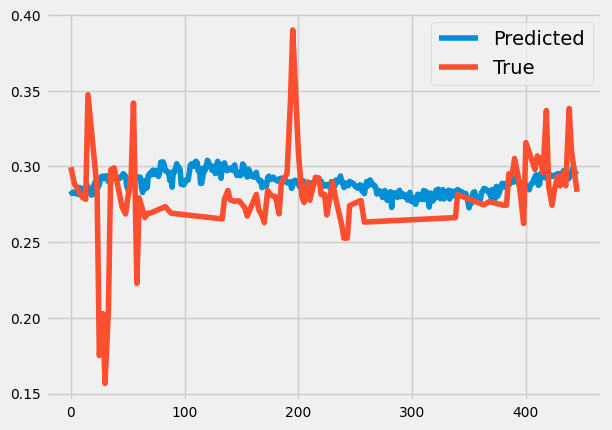

In [ ]:
plt.plot(range(len(test_y)), y_prediction, label='Predicted')
plt.plot(range(len(test_y)), test_y, label='True')
plt.legend()

In [ ]:
import joblib

In [ ]:
joblib.dump(model,'mlr.sav')

['mlr.sav']

## Defining LSTM Model
### LSTM models expect input in 3D ie [samples, timesteps, features]

In [ ]:
#Reshaping input data as 3D

train_X_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
test_X_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(train_X_lstm.shape, y_train.shape, test_X_lstm.shape, y_test.shape)

(2190, 1, 89) (2190,) (432, 1, 89) (432,)


In [ ]:
from keras.layers import LSTM, Dense

In [ ]:
train_X_lstm = train_X_lstm.astype(np.float32)
y_train = y_train.astype(np.float32)
test_X_lstm = test_X_lstm.astype(np.float32)
y_test = y_test.astype(np.float32)

In [ ]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, input_shape=input_shape))
    model.add(Dense(units=1))  # Output layer with 1 unit for regression
    model.compile(optimizer='adam', loss='mae')
    return model

In [ ]:
# Get the shape of one sample in your training data
input_shape = (1, X_train.shape[1])
lstm_model = create_lstm_model(input_shape)

#fit model
history = lstm_model.fit(train_X_lstm, y_train, epochs=100, batch_size=30, validation_data = (test_X_lstm, y_test), verbose=2, shuffle=False)



# # Get the shape of one sample in your training data
# input_shape = (1, train_X.shape[1])
# lstm_model = create_lstm_model(input_shape)

# #fit model
# history = lstm_model.fit(train_X_lstm, train_y, epochs=100, batch_size=30, validation_data = (test_X_lstm, test_y), verbose=2, shuffle=False)


Epoch 1/100
73/73 - 3s - loss: 0.2165 - val_loss: 0.1982 - 3s/epoch - 36ms/step
Epoch 2/100
73/73 - 0s - loss: 0.1824 - val_loss: 0.1710 - 163ms/epoch - 2ms/step
Epoch 3/100
73/73 - 0s - loss: 0.1572 - val_loss: 0.1468 - 141ms/epoch - 2ms/step
Epoch 4/100
73/73 - 0s - loss: 0.1343 - val_loss: 0.1254 - 156ms/epoch - 2ms/step
Epoch 5/100
73/73 - 0s - loss: 0.1142 - val_loss: 0.1084 - 132ms/epoch - 2ms/step
Epoch 6/100
73/73 - 0s - loss: 0.0958 - val_loss: 0.0928 - 138ms/epoch - 2ms/step
Epoch 7/100
73/73 - 0s - loss: 0.0823 - val_loss: 0.0797 - 142ms/epoch - 2ms/step
Epoch 8/100
73/73 - 0s - loss: 0.0704 - val_loss: 0.0686 - 146ms/epoch - 2ms/step
Epoch 9/100
73/73 - 0s - loss: 0.0621 - val_loss: 0.0606 - 157ms/epoch - 2ms/step
Epoch 10/100
73/73 - 0s - loss: 0.0552 - val_loss: 0.0545 - 144ms/epoch - 2ms/step
Epoch 11/100
73/73 - 0s - loss: 0.0519 - val_loss: 0.0499 - 137ms/epoch - 2ms/step
Epoch 12/100
73/73 - 0s - loss: 0.0480 - val_loss: 0.0463 - 140ms/epoch - 2ms/step
Epoch 13/100
73

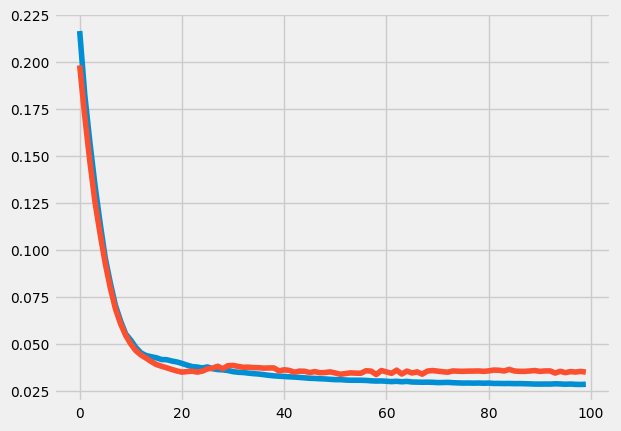

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

#### Model Evaluation

In [ ]:

from sklearn.metrics import r2_score
yhat = lstm_model.predict(test_X_lstm)
test_X_lstm = test_X_lstm.reshape(test_X_lstm.shape[0], test_X_lstm.shape[2])

mse_lstm = mean_squared_error(y_test, yhat)

print(f"The MSE is {mse_lstm}")

14/14 [==============================] - 0s 1ms/step
The MSE is 0.0021821358241140842


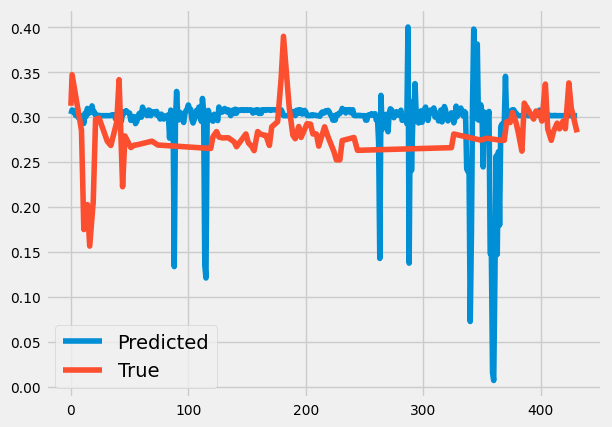

In [ ]:
plt.plot(range(len(y_test)), yhat, label='Predicted')
plt.plot(range(len(y_test)), y_test, label='True')
plt.legend()

## Defining Random Forest Model

In [ ]:
# Create a Random Forest regressor with 100 trees
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the regressor to the training data
rf_regressor.fit(train_X, train_y)

# Predict the yield values for the test data
predicted_y = rf_regressor.predict(test_X)

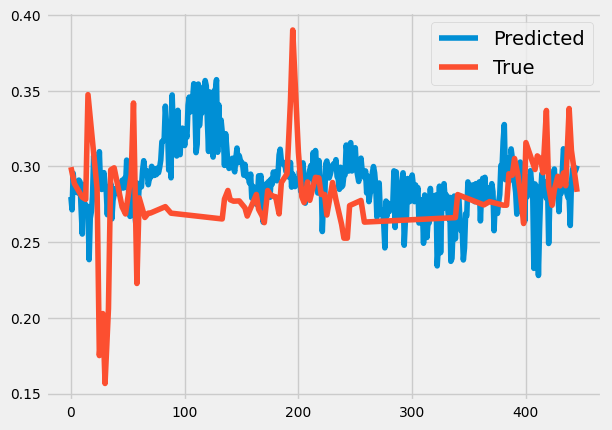

In [ ]:
plt.plot(range(len(test_y)), predicted_y, label='Predicted')
plt.plot(range(len(test_y)), test_y, label='True')
plt.legend()

#### Model Evaluation

In [ ]:
mse_rf = mean_squared_error(predicted_y, test_y)

print(f"The MSE is {mse_rf}")

The MSE is 0.0012509493854139181


## Comparing Performance of the tested models

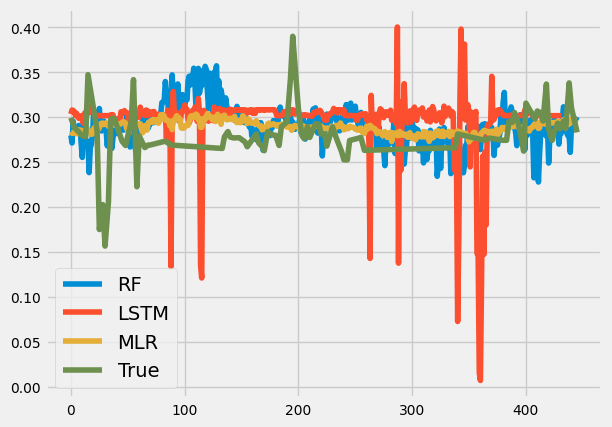

In [ ]:
plt.plot(range(len(test_y)), predicted_y, label='RF')
plt.plot(range(len(y_test)), yhat, label='LSTM')
plt.plot(range(len(test_y)), y_prediction, label='MLR')

plt.plot(range(len(test_y)), test_y, label='True')
plt.legend()

In [ ]:
data = {'model': ['LSTM', 'Random Forest', 'MLR'],
        'MSE': [mse_lstm, mse_rf, mse]}

df = pd.DataFrame(data)

print(df)

           model       MSE
0           LSTM  0.002182
1  Random Forest  0.001251
2            MLR  0.000694


### Indicating that Multiple Linear Regression(MLR) model is the best performer as it shows least error(MSE)




## Estimating crop yield from the predicted NDVI values

### Calculating the area of the Sugarcane Belt Polygon

In [ ]:
import ee

# Initialize the Earth Engine API
ee.Initialize()

# Coordinates of the polygon
polygon_coords = [
    [80.1728, 28.1124],
    [80.3233, 28.0459],
    [80.3648, 27.9413],
    [80.3476, 27.8406],
    [80.1756, 27.8007],
    [80.0897, 27.8132],
    [80.0149, 27.8557],
    [79.9669, 27.8978],
    [79.9190, 27.9468],
    [79.8889, 27.9993],
    [79.8704, 28.0641],
    [79.8015, 28.1435],
    [79.7522, 28.2381],
    [79.7847, 28.2827],
    [79.7744, 28.3554],
    [79.8495, 28.3964],
    [79.8778, 28.4119],
    [80.1728, 28.1124]  # Closing the polygon
]

# Create an Earth Engine Geometry object
polygon_ee = ee.Geometry.Polygon(polygon_coords)

# Calculate the area in square kilometers
area_square_kilometers_ee = polygon_ee.area().divide(1e6).getInfo()

# print(f"Area within the specified polygon: {area_square_kilometers_ee:.2f} square kilometers")
conversion_factor = 100

area_hectares = area_square_kilometers_ee* conversion_factor

print(f"Area within the specified polygon: {area_hectares: .2f} hectares.")

Area within the specified polygon:  206066.10 hectares.


### Calculating the yield from the NDVI values

#### We use the predictions from Random Forrest Model as they have the least MSE

In [ ]:
# convert ndvi to yield using a linear regression model
m = 5
c = 5.0

yield_pred = m * y_prediction + c
yield_act = m * test_y + c

# calculate total predicted crop yield in tonnes
crop_yield = np.sum(yield_pred) * area_hectares

# calculate total actual crop yield in tonnes
crop_yield_act = np.sum(yield_act) * area_hectares

# predicted average yearly crop yield in million tonnes
crop_yield = (crop_yield/8)/1000000

# Actual average yearly crop yield in million tonnes
crop_yield_act = (crop_yield_act/8)/1000000

print("Predicted average yearly crop yield: {:.3f} kg-hectares".format(crop_yield))
print("Actual average yearly crop yield: {:.3f} kg-hectares".format(crop_yield_act))

Predicted average yearly crop yield: 74.054 kg-hectares
Actual average yearly crop yield: 73.376 kg-hectares
